# Create Tiles

The first thing we need to do is to create the tiles. We are going to create 1deg tiles.
The raster to be used as example is a DEM corrected for forests heights released by the Brazilian National Water and Sanitation Agency, called ANADEM.
This DEM was originally published as a single GeoTIFF file with almost 200Gb of size, making it difficult to manipulate. 

For this tutorial, instead of working with the entire TIFF, I will use a croped version with the South region of Brazil. However, the same procedure can be replicated for any other GeoTiff. 

We will use Rasterio to perform the operations. 

## Open the GeoTiff

In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import rioxarray as xrio
import xarray as xr

In [3]:
%%timeit -r1 -n1
with rio.open('/data/anadem_v018/anadem_south_2.tif') as ds:
    arr = ds.read()
    print(arr.shape)

(1, 41762, 35793)
31.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
%%timeit -r1 -n1
with rio.open('/data/anadem_v018/anadem_south_2.tif') as ds:
    arr = ds.read(out_shape=(420, 360))
    print(arr.shape)
        

(1, 420, 360)
493 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
plt.imshow(arr.squeeze(), vmin=0)

NameError: name 'arr' is not defined

In [12]:
%%timeit -r1 -n1
dset = xrio.open_rasterio('/data/anadem_v018/anadem_south_2.tif')


20 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
arr = arr.rio.reproject(ds.rio.crs, shape=(420, 360))

In [36]:
dset.rio.reproject(dset.rio.crs, shape=(420, 360))

In [82]:
from affine import Affine 

def decimated_reading(file, out_shape):

    # Open the dataset with rasterio
    ds = rio.open(file)

    # Read it with the desired output shape (decimated reading)
    data=ds.read(out_shape=out_shape).squeeze()
    data[data == ds.nodata] = np.nan

    # create the lats and longs coordinates, considering the bounds and the shape
    longs = np.linspace(ds.bounds.left, ds.bounds.right, out_shape[1])
    lats = np.linspace(ds.bounds.top, ds.bounds.bottom, out_shape[0])

    arr = xr.DataArray(data=data, dims=['lat', 'long'], coords=[lats, longs])

    # set CRS and GeoTransform
    arr.rio.set_crs(ds.crs)
    transform = rio.transform.from_bounds(*ds.bounds, height=out_shape[0], width=out_shape[1])
    arr = arr.rio.write_transform(transform)

    return arr



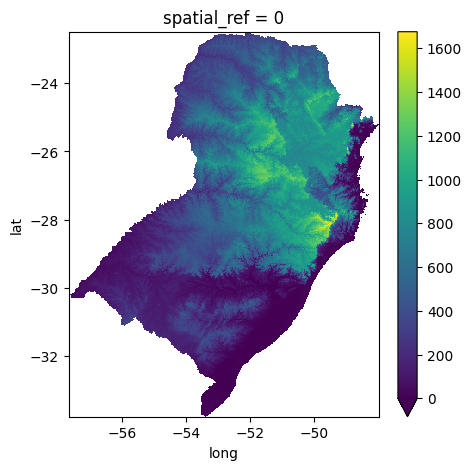

In [83]:
arr = decimated_reading('/data/anadem_v018/anadem_south_2.tif', out_shape=(420, 360))

arr.plot(vmin=0, aspect=1, figsize=(5, 5))

In [84]:
arr.rio.transform(recalc=True)

Affine(0.02679449913707502, 0.0, -57.65971398413766,
       0.0, -0.026796744925285325, -22.506301296802086)

In [49]:
arr.rio.write_transform()

Signature:
arr.rio.write_transform(
    transform: Optional[affine.Affine] = None,
    grid_mapping_name: Optional[str] = None,
    inplace: bool = False,
) -> Union[xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray]
Docstring:
.. versionadded:: 0.0.30

Write the GeoTransform to the dataset where GDAL can read it in.

https://gdal.org/drivers/raster/netcdf.html#georeference

Parameters
----------
transform: affine.Affine, optional
    The transform of the dataset. If not provided, it will be calculated.
grid_mapping_name: str, optional
    Name of the grid_mapping coordinate to store the transform information in.
    Default is the grid_mapping name of the dataset.
inplace: bool, optional
    If True, it will write to the existing dataset. Default is False.

Returns
-------
:obj:`xarray.Dataset` | :obj:`xarray.DataArray`:
    Modified dataset with Geo Transform written.
File:      /usr/local/lib/python3.10/dist-packages/rioxarray/rioxarray.py
Type:      method

In [24]:
ds

NameError: name 'ds' is not defined

In [3]:
import xarray as xr

In [64]:
ds.close()

In [81]:
# %%timeit -r1 -n1

# Open the dataset
ds = rio.open('/data/anadem_v018/anadem_south_2.tif')
print(ds.bounds)
print(ds.shape)

# set the desired output shape to use (decimated reading)
out_shape = (4170, 3570)
data=ds.read(out_shape=out_shape).squeeze()
data[data == ds.nodata] = np.nan

# create the lats and longs coordinates, considering the bounds and the shape
longs = np.linspace(ds.bounds.left, ds.bounds.right, out_shape[1])
lats = np.linspace(ds.bounds.top, ds.bounds.bottom, out_shape[0])

array = xr.DataArray(data=data, dims=['lat', 'long'], coords=[lats, longs])

# ds.close()

BoundingBox(left=-57.65971398413766, bottom=-33.76093416542192, right=-48.01369429479065, top=-22.506301296802086)
(41762, 35793)


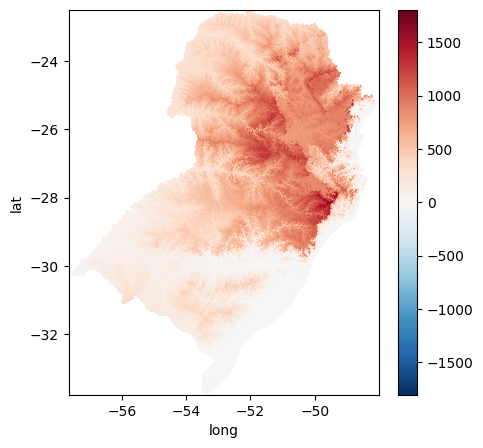

In [83]:
array.plot.imshow(aspect=1, figsize=(5, 5))

In [67]:
ds.compression

<Compression.deflate: 'DEFLATE'>

In [6]:
rio.open?

Signature:
rio.open(
    fp,
    mode='r',
    driver=None,
    width=None,
    height=None,
    count=None,
    crs=None,
    transform=None,
    dtype=None,
    nodata=None,
    sharing=False,
    **kwargs,
)
Docstring:
Open a dataset for reading or writing.

The dataset may be located in a local file, in a resource located by
a URL, or contained within a stream of bytes.

In read ('r') or read/write ('r+') mode, no keyword arguments are
required: these attributes are supplied by the opened dataset.

In write ('w' or 'w+') mode, the driver, width, height, count, and dtype
keywords are strictly required.

Parameters
----------
fp : str, file object, PathLike object, FilePath, or MemoryFile
    A filename or URL, a file object opened in binary ('rb') mode, a
    Path object, or one of the rasterio classes that provides the
    dataset-opening interface (has an open method that returns a
    dataset).
mode : str, optional
    'r' (read, the default), 'r+' (read/write), 'w' (write), or
 

Notice the raster is still huge with aprox. 40kx40k pixels. Thanks to decimated reading (more on that on a future post), we can quickly display a downscaled version of it. 

In [63]:
arr = ds.read(out_shape=(417, 357)).squeeze()
arr[arr == ds.nodata] = np.nan

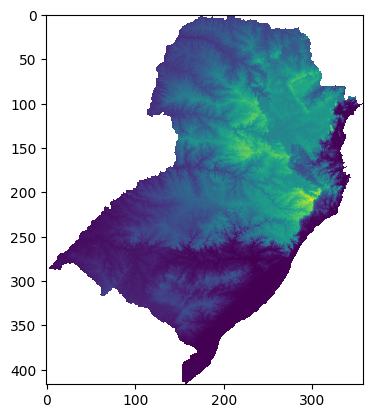

In [64]:
ax = plt.imshow(arr)

In [61]:
ax.set_ylim(0, 100)

AttributeError: 'AxesImage' object has no attribute 'set_ylim'

In [60]:
ax.get_extent()

[-0.5, 356.5, 416.5, -0.5]

In [50]:
ds.dataset_mask(out_shape=(417, 357))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)